## 적당한 '정확도'가 보장되는 모델을 '자동으로' 만들 수는 없을까?

- 알고리즘을 선택하고, 그 알고리즘에 입력해주어야 하는 파라미터들에 대한 '튜닝'은 소모적인 과정임
- 데이터의 '특성'에 따라 선택하면 좋을 알고리즘과 어울리는 파라미터를 '찾는' 문제 = AutoML 이라고 함
- AutoML 의 구현체들을 https://github.com/automl 에서 찾을 수 있으며,
    - 여기에서는 그 중에서도 별을 많이 받은 https://github.com/automl/auto-sklearn 를 Binary Classification 의 사례에 적용해보고,
    - 기존에 이 문제를 풀면서 튜닝했던 모델 ([**정기예금권유문제풀이**](https://gist.github.com/dlift/b4ebae9b898f96a979bf10bde19ab0b9)) 의 Performance (속도와 정확도 측면에서) 와 비교해본 후 ,
    - 좋다면 왜 좋은지? 개선해야 할 점이 있다면 그것이 무엇일지? 에 대해 이야기해보기로 한다.

## '정기예금가입권유' 데이터를 토대로 auto-sklearn 의 성능을 확인해보는겁니다.

In [1]:
import pandas as pd
bank = pd.read_csv("../bank.csv", sep = ",", header = 0, error_bad_lines = False)
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## 1. 세상에, .fit 함수 하나면 최적의 모델을 선택해주다니!

- 하지만 - 아무리 자동화가 되어있다고 해도, 데이터 전처리는 필요합니다. (e.g., 카테고리 변수들을 더미화한다거나, 결측치를 처리하는 것들 말이죠)

In [2]:
# 데이터전처리
# 1) 결측치 (unknown) 를 최빈값으로 넣어주기
dispose_cols = ['job', 'education', 'contact']
for col in dispose_cols:
    most_common = pd.get_dummies(bank[col].dropna()).sum().sort_values(ascending = False).index[0]
    def replace_most_common(x):
        if x == 'unknown':
            return most_common
        else:
            return x
    bank[col] = bank[col].map(replace_most_common)

# 2) 카테고리변수를 더미화시키기
df = pd.concat([bank[bank.columns[bank.dtypes == 'int']], 
                pd.get_dummies(bank[[col for col in bank.columns[bank.dtypes == 'object'] if col != 'deposit']])], 
                axis = 1)
df = pd.concat([df, bank['deposit']], axis = 1)
df['target'] = df.deposit.apply(lambda x : True if x == 'yes' else False)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[[col for col in df.columns if col not in ['deposit', 'target']]],
                                                    df['target'], test_size = 0.33)

## 돌려봅시다. 참고로! searching time 및 로그위치에 대한 정보는 꼭 확인해두자구요.

- time_left_for_this_task 라는 옵션이 있음 => search time 을 정해두자. 라는 것
    - default = 1시간입니다. 이래서 확인하자고 그랬어요. ㅠ  => 저는 5분으로 설정하고 돌려보렵니다.
- tmp_folder : 이게 바로 로그 위치 => 로그를 확인하면서 당최 auto-sklearn 이 어떻게 동작하는 지에 대한 감을 잡을 수 있다구요!

In [3]:
%%time
import autosklearn.classification
from sklearn.model_selection import train_test_split
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task = 300,
                                                          tmp_folder = "./log/") # 5분 탐색을 하도록 해보자
automl.fit(x_train, y_train)

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (299.050460)
CPU times: user 4.96 s, sys: 1.74 s, total: 6.7 s
Wall time: 4min 55s


## 돌려본 결과, auto-sklearn 이 최종적으로 선택한 모델에 대한 정보는 다음과 같습니다.

- 총 8개의 모델을 앙상블한 결과입니다.
- RandomForest 모델의 weight 가 가장 크네요. 이것의 n_estimator 는 100 입니다. (그 밖에 다른 파라미터들에 대한 정보도 잘 적혀있군요.)

In [12]:
print(len(automl.get_models_with_weights()))
for info in automl.get_models_with_weights():
    print("\n")
    print("model, weight : {}\n{}".format(info[0], "-" * 10 + "\n" + str(info[1])))

8


model, weight : 0.32000000000000006
----------
SimpleClassificationPipeline({'categorical_encoding:__choice__': 'one_hot_encoding', 'classifier:random_forest:max_features': 0.5, 'balancing:strategy': 'none', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'True', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:min_samples_leaf': 1, 'rescaling:__choice__': 'standardize', 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'classifier:__choice__': 'random_forest', 'imputation:strategy': 'mean', 'categorical_encoding:one_hot_encoding:minimum_fraction': 0.01, 'classifier:random_forest:n_estimators': 100, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'preprocessor:__choice__': 'no_preprocessing'},
dataset_properties={
  'task': 1,
  'target_type'

## 얼마나 정확할까요?

- AUC : 0.9 그리고 Precision : 0.82, Recall : 0.83
- 참고로, [**정기예금권유문제풀이**](https://gist.github.com/dlift/b4ebae9b898f96a979bf10bde19ab0b9) 에서 사용한 GradientBoostingClassifier 를 tuning 한 결과는,
- AUC : 0.92, Precision : 0.83, Recall : 0.84
- 즉, 성능차이가 그렇게 크지 않다. 라는 것을 확인할 수 있습니다. => 우와! 그냥 이걸로 대체해서 쓰면 참 좋겠네요.

In [10]:
model = automl

print(y_test.reset_index().groupby('target').size())
y_predict = model.predict(x_test)
y_predict_score = model.predict_proba(x_test)[:, 1]
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
print("Accuracy : {}, AUC : {}, Precision : {}, Recall : {}".format(
    accuracy_score(y_test, y_predict),
    roc_auc_score(y_test, y_predict_score),
    precision_score(y_test, y_predict),
    recall_score(y_test, y_predict)
))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict)

target
False    1943
True     1741
dtype: int64
Accuracy : 0.8382193268186754, AUC : 0.9096620129757834, Precision : 0.8236291690220463, Recall : 0.8368753589890867


array([[1631,  312],
       [ 284, 1457]])

## 결론적으로 이 package 를 잘 쓰면 될 거 같지만, 무작정 쓸 수는 없죠!  동작원리를 파헤쳐보자구요.

---

## 2. auto-sklearn 에서는 모델/파라미터를 어떤 방식으로 골라주는 걸까요?

- 일단 auto-sklearn 의 architecture 중 meta-learning 부분을 살펴봅시다.
- 출처 : https://papers.nips.cc/paper/5872-efficient-and-robust-automated-machine-learning.pdf

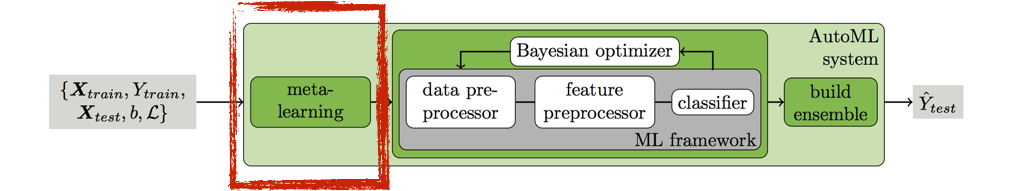

In [198]:
from IPython.display import Image                        
url='../metalearning_autosklearn.png'
Image(url,width=900, height=900)

### 1) 전체적인 동작은 이렇게 흘러갑니다.

- 1) 데이터가 들어오면, 우선 이 데이터에 어울릴 알고리즘 / 파라미터들을 알려주는 meta-learner 가 있다.
- 2) 이 meta-learner 가 알려주는 **알고리즘 / 파라미터 셋 '들'** 을 추천받는다.
- 3) ** 앙상블 기법을 활용해 ** 해당 알고리즘 / 파라미터 셋 '들'의 최적화를 진행한다.

---

### 2) 어? 그럼 meta-learning 은 어떻게, 들어온 데이터에 '알맞은' '알고리즘 / 파라미터들' 을 알려줄까요?

- 논문에서는 meta-learning 의 컨셉을 아래와 같은 문장으로 소개하고 있습니다.


**"More specifically, for a large number of datasets, we collect both performance data and a set
of meta-features, i.e., characteristics of the dataset that can be computed efficiently and that help to
determine which algorithm to use on a new dataset"**


- 즉,


    - 1 사전에 데이터별로 가지고 있는 meta-features 들과 {알고리즘/파라미터에 따른} 퍼포먼스를 기록해 둠
    - 2 새로운 데이터셋이 들어왔을 때 그것의 meta-features 와 기존 데이터셋들의 meta-features 를 비교해서 가장 유사한 기존 데이터셋을 찾아냄
    - 3 그리고 그 기존 데이터셋을 돌렸을 때, 가장 이상적이었던 알고리즘 / 파라미터 조합을 알려줌


- 이렇게 동작한다고 볼 수 있습니다. 

---

### 정말 그렇게 동작하는 지, bank.csv 의 데이터로 한번 검증해봅시다!

#### 오 역시!, 우선 bank.csv 의 데이터를 46개 meta-features 라 불리는 속성들로 표현해줍니다

- 타겟의 분포, 결측치의 수, 칼럼별 분포 (첨도와 왜도), 행과 열의 비율, ... 등으로 구성됨

In [7]:
import autosklearn.metalearning.metafeatures.metafeatures as meta_features
mf = meta_features.calculate_all_metafeatures(x_train.values, y_train.reshape(-1),
                                              [True if typ == 'object' else False for typ in x_train.dtypes], 
                                              'bank')
ft_cols = \
['ClassOccurences',
 'Kurtosisses',
 'MissingValues',
 'NumSymbols',
 'PCA',
 'Skewnesses']
for col in ft_cols:
    mf.metafeature_values.pop(col)
    
ret = {}
for _, item in mf.metafeature_values.items():
    ret.update({
        item.name : item.value
    })
ret = pd.DataFrame([ret]).T.rename(columns = {0 : 'value'})
print("size of meta-features : {}".format(ret.shape[0]))
ret

size of meta-features : 46


,value
ClassEntropy,0.997292
ClassProbabilityMax,0.530623
ClassProbabilityMean,0.500000
ClassProbabilityMin,0.469377
ClassProbabilitySTD,0.030623
DatasetRatio,0.006419
InverseDatasetRatio,155.791667
KurtosisMax,119.945355
KurtosisMean,18.553282
KurtosisMin,-1.988174


#### 그리고 bank.csv 를 표현하는 46개의 meta-features 와 '가장 가까운 거리'를 가지고 있는 데이터셋을 찾아주는군요

- 847_acc 라는 이름의 데이터셋이 bank.csv 와 가장 가까운 특성을 가지고 있다고 판단해줌

    - 참고로 847_acc 는 기존에 auto-sklearn에서 충분히 알고리즘/파라미터 서치를 한! openml (https://www.openml.org/) 내의 데이터 셋 중 하나.
    - 결과는 차례대로, '데이터셋이름' | 'ㅜdistance (minkowski distance)' (작을 수록 유사함) | '이 데이터셋을 최적으로 돌릴 수 있는 알고리즘 / 파라미터 조합에 대한 인덱스'

In [6]:
import autosklearn.pipeline.classification
import autosklearn.metalearning.optimizers.metalearn_optimizer.metalearner as metalearner
from autosklearn.metalearning.metalearning.meta_base import MetaBase

data_dir = "./resources/auto-sklearn/test/test_metalearning/pyMetaLearn/test_meta_base_data/"
cs = autosklearn.pipeline.classification.SimpleClassificationPipeline().get_hyperparameter_search_space()
meta_base = MetaBase(cs, data_dir)
meta_base.add_dataset('bank', mf)
meta_optimizer = metalearner.MetaLearningOptimizer('bank', cs, meta_base)

#########################################################################################################

meta_optimizer._learn()

[('847_acc', 1.4629541374601547, '2'),
 ('904_acc', 1.6831576328641724, '24'),
 ('743_acc', 1.8179442530168246, '23'),
 ('833_acc', 1.8493411398243662, '3'),
 ('806_acc', 1.85475986935783, '21'),
 ('849_acc', 1.9269421850300184, '17'),
 ('797_acc', 1.9872424675651155, '15'),
 ('741_acc', 2.0594483947626427, '8'),
 ('60_acc', 2.1048945079642176, '11'),
 ('866_acc', 2.1523318024036113, '10'),
 ('718_acc', 2.2468864707224658, '16'),
 ('772_acc', 2.8415717709696886, '12'),
 ('991_acc', 2.877377536653853, '22'),
 ('871_acc', 2.9049458721329442, '7'),
 ('846_acc', 3.1857402932973398, '14'),
 ('734_acc', 4.0202241368144591, '18'),
 ('23_acc', 4.7461388967895486, '4'),
 ('1020_acc', 4.8109234382254584, '20'),
 ('14_acc', 4.8913679891936575, '19'),
 ('391_acc', 6.3434507029145299, '5'),
 ('392_acc', 6.9676100409495909, '13'),
 ('401_acc', 7.0739808956009096, '6'),
 ('1000_acc', 7.4996507984261651, '1'),
 ('1116_acc', 7.5031063000544291, '9')]

#### 여기서 잠깐!, 847_acc 과 bank.csv, 그리고 random 한 다른 데이터 (1116_acc) 를 뽑아서, 이 세 개의 데이터 특성을 그래프로 본다면?

- 847_acc / bank.csv 는 어느 정도 유사한 데 비해 => 1116_acc 는 상이하다라는 것을 확인해볼 수 있음

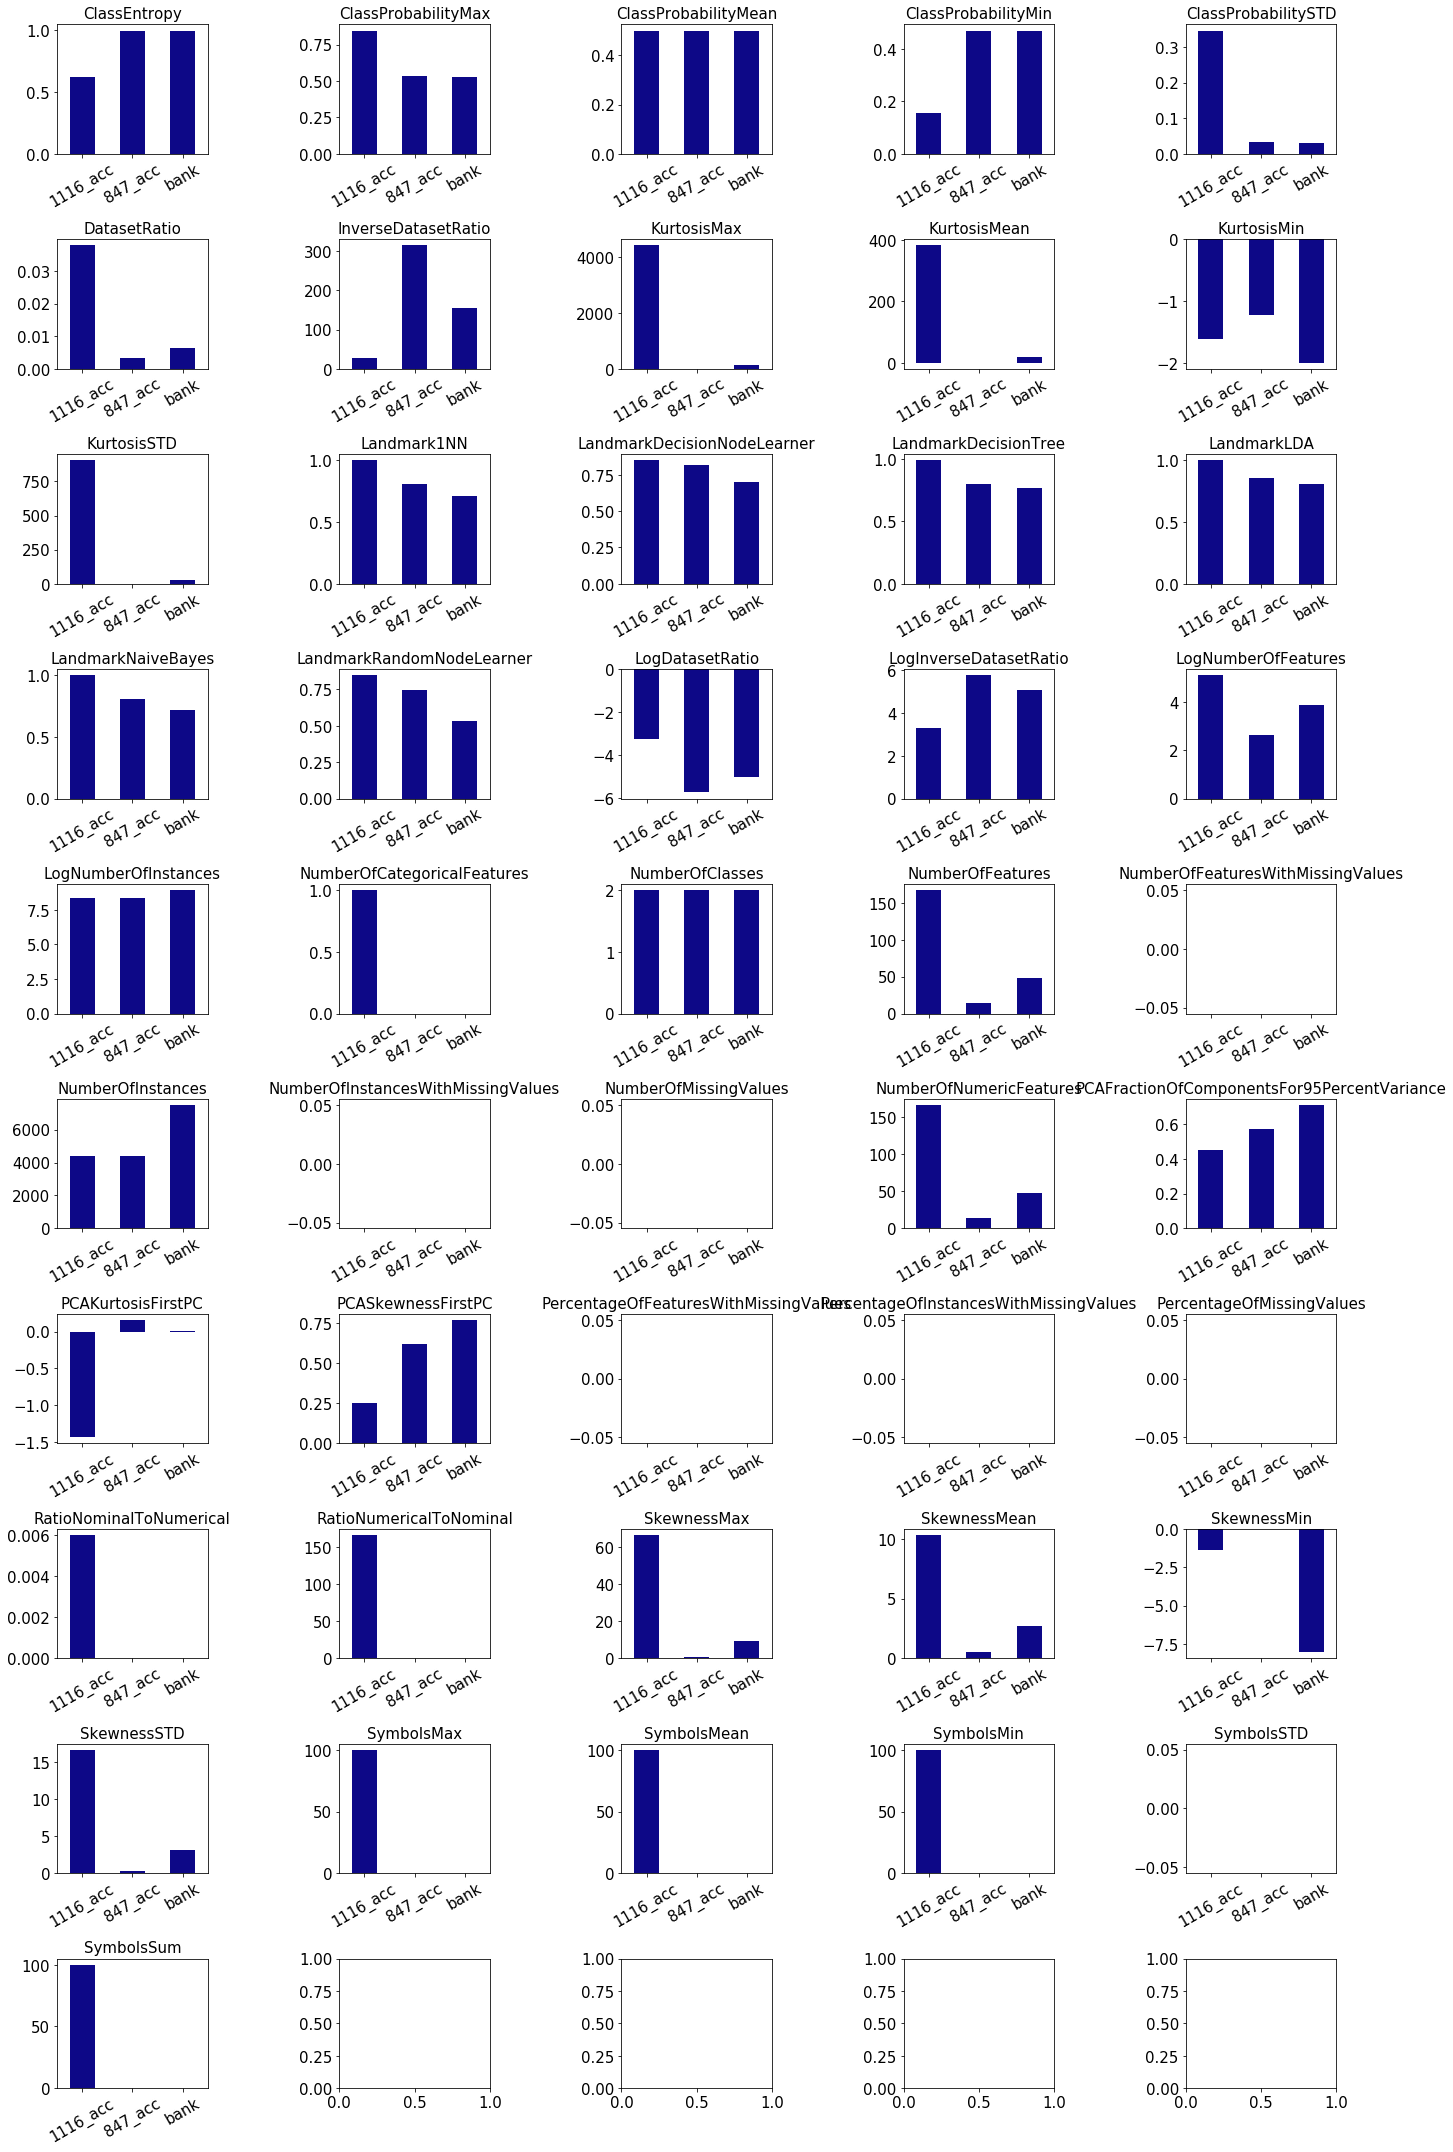

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = 15;plt.rcParams['ytick.labelsize'] = 15

_, ax = plt.subplots(10, 5, figsize = (20, 30))
stat = meta_optimizer.meta_base.metafeatures
cnt = 0
for col in stat.columns:
    cnt = cnt + 1
    idx = int((cnt-1) / 5 + 1)
    idy = int((cnt-1) % 5 + 1)
    stat[stat.index.isin(['847_acc', 'bank', '1116_acc'])][col].plot(kind = 'bar', ax = ax[idx - 1, idy - 1], 
                                                                     cmap = 'plasma', rot = 30)
    ax[idx - 1, idy - 1].set_title(col, size = 15)
plt.tight_layout()

#### 여튼, 마지막으로 bank.csv 와 같은 데이터 특성에 가장 잘 어울릴 법한 알고리즘 / 파라미터 셋을 찾아줍니다

- 즉,
- bank.csv 와 비슷한 데이터 특성을 가진 847_acc 와 같은, 17개의 데이터 셋을 찾은 후,
- 해당 데이터 셋들 각각에 매칭되어 있는 알고리즘 / 파라미터 셋 '들' 을 준다.

    - 아래의 결과는 17개의 알고리즘 / 파라미터 셋들에 대한 정보 중 2개만 나열해 둔 것임

In [13]:
alternatives = meta_optimizer.metalearning_suggest_all()
print("size of configurations : {}\n".format(len(alternatives)))
print("=" * 50)
print("\n")
for i in range(2):
    print(alternatives[i])
    print('-' * 50)
    print("\n")

# for _, item in enumerate(alternatives[0]):
#     print("{} : {}".format(item, alternatives[0][item]))

size of configurations : 17



Configuration:
  balancing:strategy, Value: 'none'
  categorical_encoding:__choice__, Value: 'no_encoding'
  classifier:__choice__, Value: 'random_forest'
  classifier:random_forest:bootstrap, Value: 'True'
  classifier:random_forest:criterion, Value: 'gini'
  classifier:random_forest:max_depth, Constant: 'None'
  classifier:random_forest:max_features, Value: 0.5
  classifier:random_forest:max_leaf_nodes, Constant: 'None'
  classifier:random_forest:min_impurity_decrease, Constant: 0
  classifier:random_forest:min_samples_leaf, Value: 1
  classifier:random_forest:min_samples_split, Value: 2
  classifier:random_forest:min_weight_fraction_leaf, Constant: 0
  classifier:random_forest:n_estimators, Constant: 100
  imputation:strategy, Value: 'mean'
  preprocessor:__choice__, Value: 'no_preprocessing'
  rescaling:__choice__, Value: 'minmax'

--------------------------------------------------


Configuration:
  balancing:strategy, Value: 'none'
  categorical_enc

#### 근데 알고리즘, 파라미터 서치는 어떻게 했을까요? 


#### 즉, 847_acc 와 같은 데이터 특성에 가장 잘 어울릴 법한 알고리즘 / 파라미터 셋은 어떻게 찾았을까요? 설마 그 많은 조합을 다 돌려보고 기록해둔 건 아니겠죠?

- randomforest 혹은 adaboost 의 파라미터 조합은 상당히 많은 데,
    - 그 많은 것을 다 돌린 후, 가장 정확도가 뛰어난 것을 고르는 것은 사실상 불가능함
    
    
    
- 적당한 파라미터 조합 스페이스를 만든 후, Bayesian Optimization 기법 (SMAC - Sequential Model-Based Optimization for General Algorithm Configuration) 을 이용해서 가장 정확도가 뛰어난 조합을 기록해 둔 것임

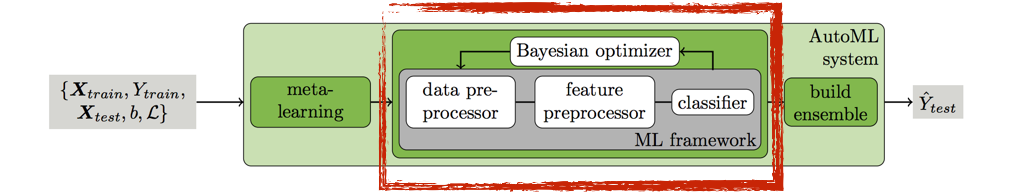

In [204]:
# 바로 이 박스에서 설명하고 있는 부분!
from IPython.display import Image
url='../bo_autosklearn.png'
Image(url,width=900, height=900)

#### 즉, 아래와 같은 과정을 '미리' 거친 후, 그 결과를 가지고 있다라는 겁니다.

- 1) 얻은 데이터에 대해 서치할 전처리 방법, 알고리즘, 파라미터 조합을 러프하게 선정해둔다.
- 2) **Bayesian Optimization** (여기서는 SMAC = Sequential Model-Based Optimization for General Algorithm Configuration, https://github.com/automl/SMAC3) 을 이용해서 가장 정확도가 우수한 기준으로, 전처리 - 알고리즘 - 파라미터 조합을 선택한다.
- 3) 결과를 저장한다.

#### Bayesian Optimization 을 이용해서 알고리즘 - 파라미터 조합을 선정한다! 라는 말을 좀 더 자세하게 알아보죠.

- 아래와 같이 "특정 데이터 셋에 대해, **알고리즘 & 파라미터 조합의 변화에 따라 정확도가 '이렇게' 움직이더라!** 라고 알려주는 함수"가 있다고 합시다.

Text(0,0.5,'정확도')

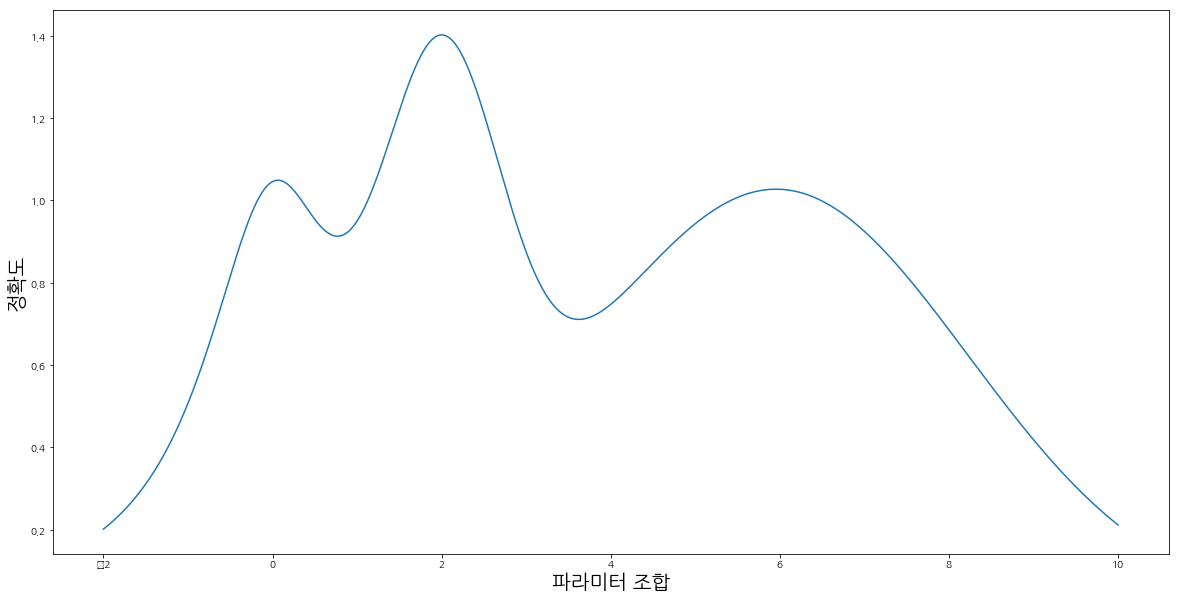

In [1]:
import numpy as np
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

x = np.linspace(-2, 10, 10000).reshape(-1, 1) ; y = target(x)

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'NanumGothic'
_, ax = plt.subplots(figsize = (20, 10))
ax.plot(x, y) ; ax.set_xlabel("파라미터 조합", size = 20) ; ax.set_ylabel('정확도', size = 20)

#### 이 함수는 '특정 데이터 셋'에 한해, '모든 알고리즘 & 파라미터 조합' 에 대한 '정확도'를 말해주는 녀석입니다.

- 즉, 이 함수를 알 수만 있다면 바로 이런 데이터셋의 특성 (위에서 meta-features 라고 했죠?) 과 유사한 데이터셋의 정확도를 가장 높여줄 알고리즘 & 파라미터 조합을 찾을 수 있다라는 말이죠.
- 그런데, 이 함수를 어떻게 구할 수 있을까요?

#### 일단 '어떤 알고리즘 & 파라미터 조합' 에 대해서도 '정확도' 가 0 인 기본 모양을 그려봅시다.

Text(0,0.5,'정확도')

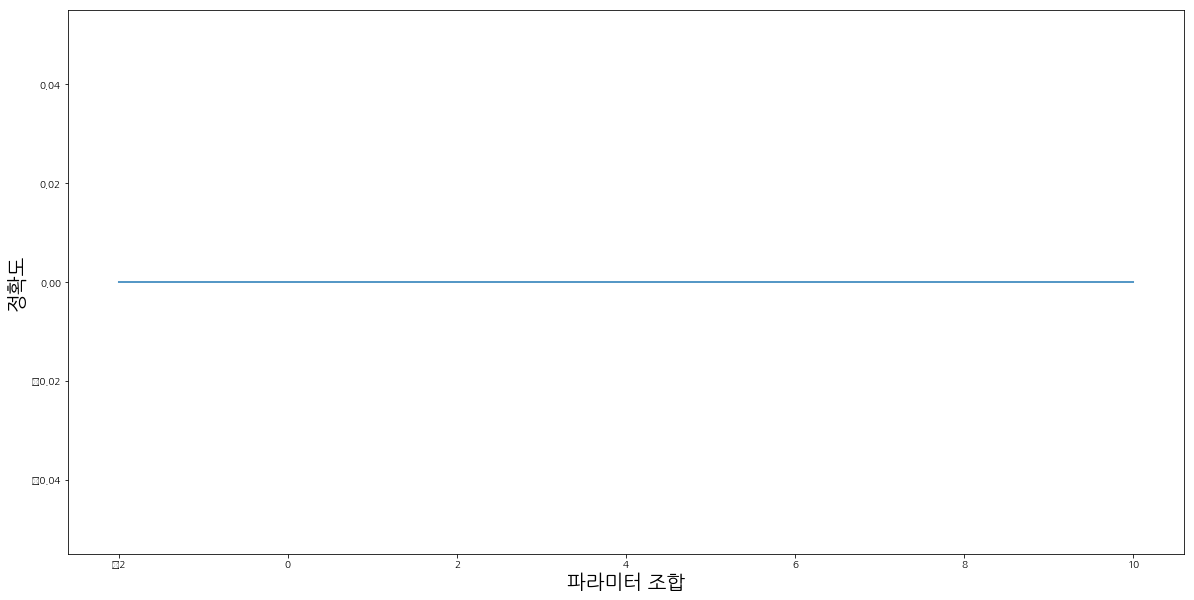

In [10]:
_y = np.repeat(0, 10000)
_, ax = plt.subplots(figsize = (20, 10))
ax.plot(x, _y) ; ax.set_xlabel("파라미터 조합", size = 20) ; ax.set_ylabel('정확도', size = 20)

#### 그리고 이 모양을 시작으로 관측치 (알고리즘 & 파라미터 조합과 그 때의 정확도) 를 하나, 둘 넣어가면서 이 기본 모양을 변화시켜보는 거에요!
#### 먼저 아래와 같이 일단 2개 정도만 골라서 정확도를 측정한 관측치들을 가지고 함수의 모양을 유추해봅시다.




- 그럼 아래와 같은 그래프가 나올 겁니다.
- 그래프는 두 종류가 나올텐데, 여기서는 위의 녀석만을 '일단' 보기로 합시다.
- 위의 녀석은 아래와 같은 component 들로 구성되어 있습니다.


    - 빨간색 점 : 2개의 관측치 (특정 데이터 셋을 2개의 선택된 알고리즘 & 파라미터 조합으로 각각 돌렸을 때의 정확도)
    - 파란색 선 : 우리가 알고 싶은 함수 (타겟)
    - 점선     : 두 점을 토대로 임의의 알고리즘 & 파라미터 조합이 들어왔을 때, 정확도를 예측한 점들을 이은 선
    - cyan 색 영역 : 각 알고리즘 & 파라미터 조합 (여기서는 X 라 표현된) 에 대한 예측 정확도 각각의 95% 신뢰구간들 (쉽게 말해 점선이 위 아래로 출렁일 수 있는 정도라고 생각하면 될 거 같아요!)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    1.34506 |    2.2605 | 
    2 | 00m00s |    0.21043 |   -1.9477 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 


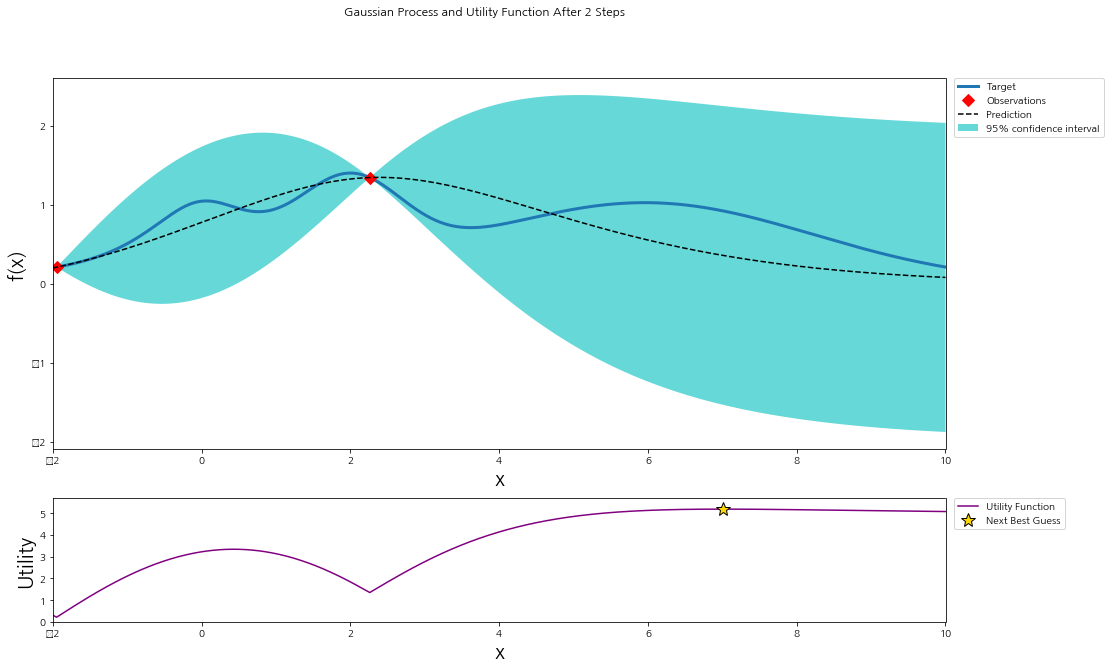

In [8]:
from bayes_opt import BayesianOptimization
bo = BayesianOptimization(target, {'x': (-2, 10)})
bo.maximize(init_points=2, n_iter=0, acq='ucb', kappa=5)
plot_gp(bo, x, y)

#### 이렇게 2 개의 알고리즘 & 파라미터 조합 ~ 그 때의 정확도를 이용해서, 함수 전체의 모양을 맞추려니까 잘 안 맞추어지긴 합니다.

- 그래서 한 개의 알고리즘 & 파라미터 조합 ~ 정확도, 에 대한 관찰을 더 해보고 -> 이것을 추가해서 함수 모양을 다시 생성해보는 겁니다.
- 그런데, '어떤' 한 개의 알고리즘 & 파라미터 조합에 대한 관찰을 더 해봐야 할까요?


    - 가장 점선이 출렁일 수 있는 가능성이 큰 지점을 줄여나가는 것이 좋을 거 같아요. 그게 함수의 모양을 잡아나가는 데에 가장 큰 기여를 할 테니까요.
    - 다시 말해, cyan 영역이 위 아래로 가장 긴 지점을 고르자라는 말이죠, 바로 아래와 같이 빨간색 점선이 그려진 지점이요!

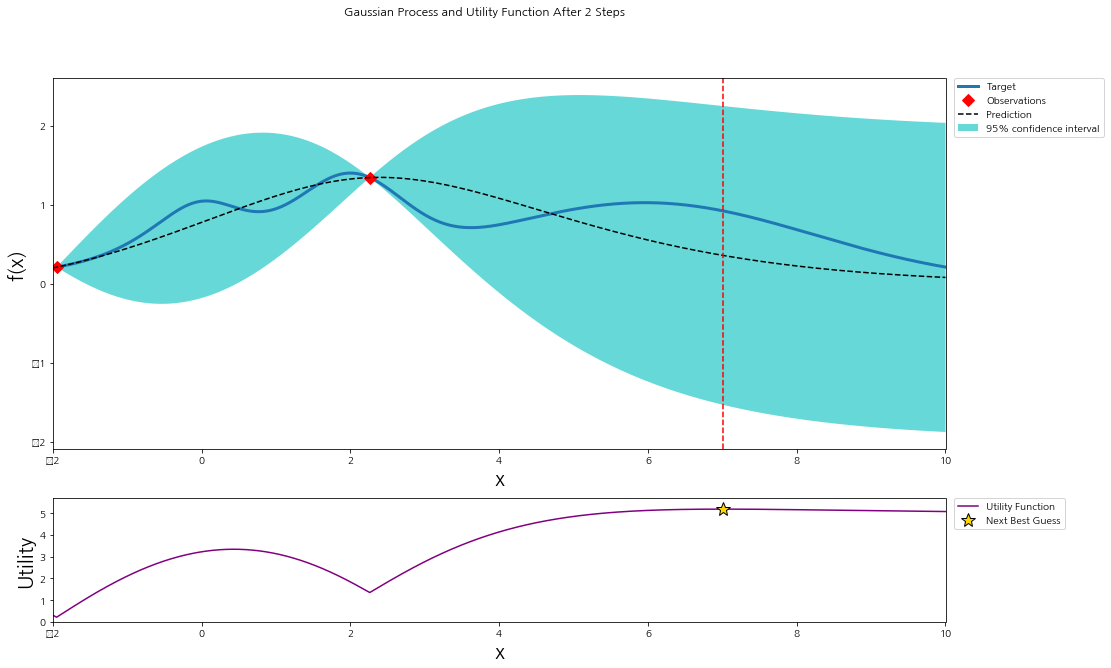

In [14]:
plot_gp_w_vline(bo, x, y)

#### 이 빨간색 점선에 해당되는 알고리즘 & 파라미터 조합에 대한 관측치를 더해서 함수 모양을 다시 생성해봅시다.

#### 자, 이 지점을 추가하니까 함수의 모양이 이렇게 달라집니다.

- 이런식으로 몇 개의 지점만 더 추가해주면 추정된 함수의 모양이 점점 우리가 알고 싶은 그 함수의 모양에 유사해진다는 것을 볼 수 있습니다.
- 즉, 모든 지점에 대한 관찰이 아닌 몇 개의 지점에 대한 관찰만으로도 특정 데이터 셋의 정확도를 가장 높일 수 있는 알고리즘 & 파라미터 조합을 발견케해주는 함수를 발견할 수 있다라는 겁니다!

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    3 | 00m01s |    0.92386 |    7.0052 | 


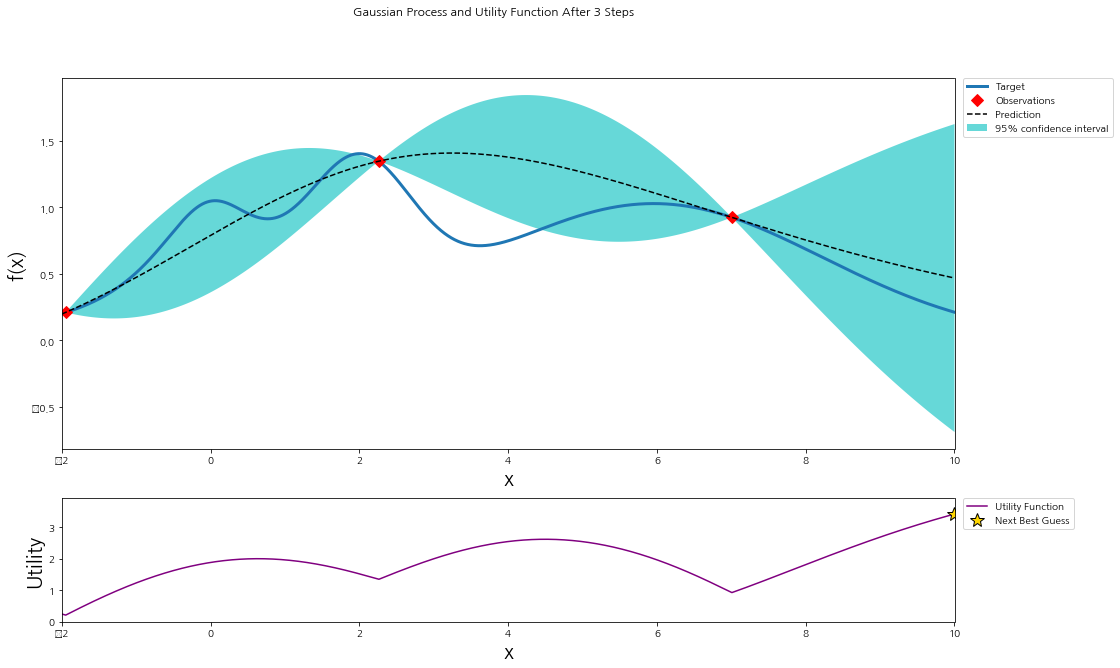

In [15]:
bo.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(bo, x, y)

#### 정리하자면,

- auto-sklearn 은 '데이터셋의 특성'과 '그것의 정확도를 가장 높이는 알고리즘 & 파라미터 조합에 대한 정보' 를 가지고 있어서, 입력된 데이터 셋의 특성과 가장 비슷한 데이터 셋을 찾아 그 데이터 셋의 정확도를 가장 높이는 알고리즘 & 파라미터 조합 정보를 추천해준다.


- 그런데, auto-sklearn 이 가지고 있는 위의 정보를 얻기 위해서는, 데이터 셋별로 너무나 많은 알고리즘 & 파라미터 조합에 대한 정확도 관측을 해야 하는 아픔이 있다.


    - 이것을 개선하기 위해, Bayesian Optimization 기법을 각 데이터 셋별로 활용한 것인데,
    - 이 기법을 이용하면 각 데이터 셋별로, 알고리즘 & 파라미터 조합과 정확도에 대한 관계를 몇 개의 관측치를 통해서도 얻어낼 수 있다.
    - 그리고 이렇게 얻어낸 알고리즘 & 파라미터 조합과 정확도에 대한 관계를 이용해서 데이터 셋별로 가장 뛰어난 정확도를 가진 알고리즘 & 파라미터 조합을 찾아내 기록할 수 있다라는 것이다.


## 3. 자, 마지막으로 추천된 알고리즘/파라미터들을 어떻게 조합하나요?

- 논문에서는 일단 아래와 같은 문장으로, 단일 모델 보다 모델들을 앙상블해서 이용하는 것이 훨씬 효과적이다. 라고 주장하고 있습니다.
- 즉, 추천된 알고리즘 & 파라미터 조합으로 이루어진 개별 모델들을 앙상블해서 최종모델을 만든다. 라는 것인데요.

** It is well known that ensembles often outperform individual models, and that effective
ensembles can be created from a library of models.**


- 앙상블을 할 때, 아래와 같이 greedy 한 방법으로 진행하는 것이, stacking 등과 같은 방법에 비해서 효과적이다. 라는 것을 주장하고 있습니다.
- 참고, http://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml04.icdm06long.pdf


    - 추천된 알고리즘 / 파라미터를 하나 씩 추가하면서 정확도를 본다.
    - 즉, A, B 두 개가 추가되었다면 전체 모델 E = w1 * A + w2 * B  의 형태가 될 것이다. (w1, w2 는 weight)
    - weight 는 uniform distribution 을 따른다. 즉, 2개의 세트가 앙상블 과정에서 추가되었다면 각각은 .5 의 weight 를 가지게 된다
    - 물론, 중복되어서 추가할 수 있다. A (알고리즘 / 파라미터) 세트 2개 + B 세트 하나. 이렇게 말이다.
        - 이 때는, A 세트에 대한 weight 가 .66, B 세트는 .33 이 될 것이다.

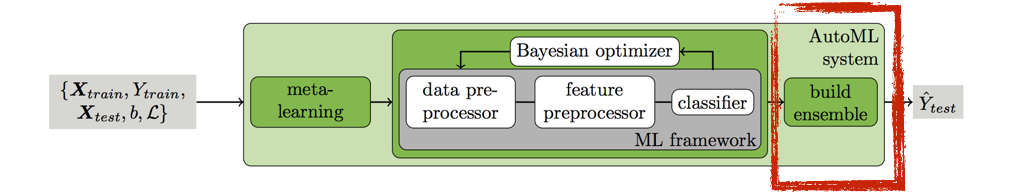

In [203]:
from IPython.display import Image                        
url='../ensemble_autosklearn.png'
Image(url,width=900, height=900)

#### bank.csv 의 경우를 살펴볼까요?

- bank.csv 는 17개의 알고리즘 & 파라미터 들을 추천받았죠?
- 이것들이 어떻게 추가되는지는 아래의 로그를 통해 볼 수 있습니다.

In [ ]:
# 일단, 진도 여기까지만!

In [ ]:
def _fast(self, predictions, labels):
    """Fast version of Rich Caruana's ensemble selection method."""
    self.num_input_models_ = len(predictions)

    ensemble = []
    trajectory = []
    order = []

    ensemble_size = self.ensemble_size

    if self.sorted_initialization:
        n_best = 20
        indices = self._sorted_initialization(predictions, labels, n_best)
        for idx in indices:
            ensemble.append(predictions[idx])
            order.append(idx)
            ensemble_ = np.array(ensemble).mean(axis=0)
            ensemble_performance = calculate_score(
                labels, ensemble_, self.task_type, self.metric,
                ensemble_.shape[1])
            trajectory.append(ensemble_performance)
        ensemble_size -= n_best

    for i in range(ensemble_size):
        scores = np.zeros((len(predictions)))
        s = len(ensemble)
        if s == 0:
            weighted_ensemble_prediction = np.zeros(predictions[0].shape)
        else:
            ensemble_prediction = np.mean(np.array(ensemble), axis=0)
            weighted_ensemble_prediction = (s / float(s + 1)) * \
                                           ensemble_prediction
        for j, pred in enumerate(predictions):
            fant_ensemble_prediction = weighted_ensemble_prediction + \
                                       (1. / float(s + 1)) * pred
            scores[j] = calculate_score(
                solution=labels,
                prediction=fant_ensemble_prediction,
                task_type=self.task_type,
                metric=self.metric,
                all_scoring_functions=False)
        best = np.nanargmax(scores)
        ensemble.append(predictions[best])
        trajectory.append(scores[best])
        order.append(best)

        # Handle special case
        if len(predictions) == 1:
            break

    self.indices_ = order
    self.trajectory_ = trajectory
    self.train_score_ = trajectory[-1]